### Classify entries into Mandrill and non-Mandrill entries using a naive Bayes classifier treating the entry as a bag of words

In [1]:
from googletrans import Translator
import openpyxl
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Read the data from Excel 

In [2]:
def flag_data_in_excel(file_path):
    data = []
    flag = []
    
    workbook = openpyxl.load_workbook(file_path)

    sheet1 = workbook.worksheets[0]
    for row in sheet1.iter_rows(min_row=2, max_row=151, min_col=1, max_col=1, values_only=True):
        for cell in row:
            data.append(cell)
            flag.append(1)

    sheet2 = workbook.worksheets[1]
    for row in sheet2.iter_rows(min_row=2, max_row=151, min_col=1, max_col=1, values_only=True):
        for cell in row:
            data.append(cell)
            flag.append(0)
            
    return data, flag

file_path = "mandrill.xlsx"
data, flag = flag_data_in_excel(file_path)

C:\Users\oskar\anaconda3\Lib\site-packages\openpyxl\reader\excel.py:228: UserWarning: Unknown extension is not supported and will be removed
  ws_parser.bind_all()


## Clean the data from links and nicknames (@...)

In [3]:
def clean_data(data):
    pattern_at = r'\w*@\w*'
    pattern_link = r'[(]?[\s]?http[s]?\S+[\s]?[)]?'
    for i in range(len(data)):
        data[i] =  re.sub(pattern_at, '', data[i])
        data[i] =  re.sub(pattern_link, '', data[i])
    return data

data = clean_data(data)

## Translate the data into English

In [4]:
def translate_data(data, target_language='en'):
    translator = Translator()
    for i in range(len(data)):
        data[i] = translator.translate(data[i] , dest=target_language).text
    return data

data = translate_data(data)

## Make pipeline from CountVectorizer and MultinomialNB and perform training

In [5]:
X = np.array(data).reshape(-1)
y = np.array(flag).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)

In [6]:
model = make_pipeline(CountVectorizer(min_df=3, stop_words='english'), MultinomialNB())
model.fit(X_train, y_train)
model.score(X_test, y_test)
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
model.score(X_test, y_test)

0.8787878787878788

## Plot confusion matrix (1 - Mandrill app related, 0 - unrelated)

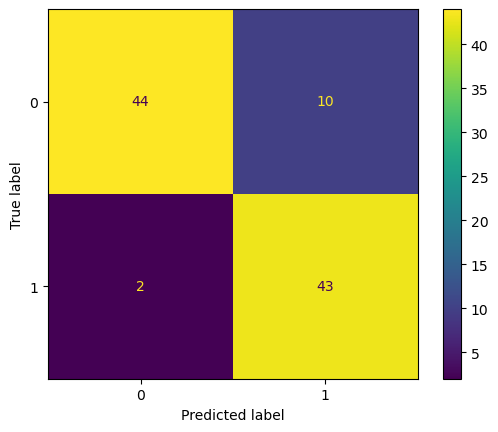

In [7]:
disp.plot()

## Plot probablities P( word | class)

In [8]:
probs = np.exp(model.steps[1][1].feature_log_prob_)
words = [x[0] for x in sorted(model.steps[0][1].vocabulary_.items(), key=lambda x:x[1])]

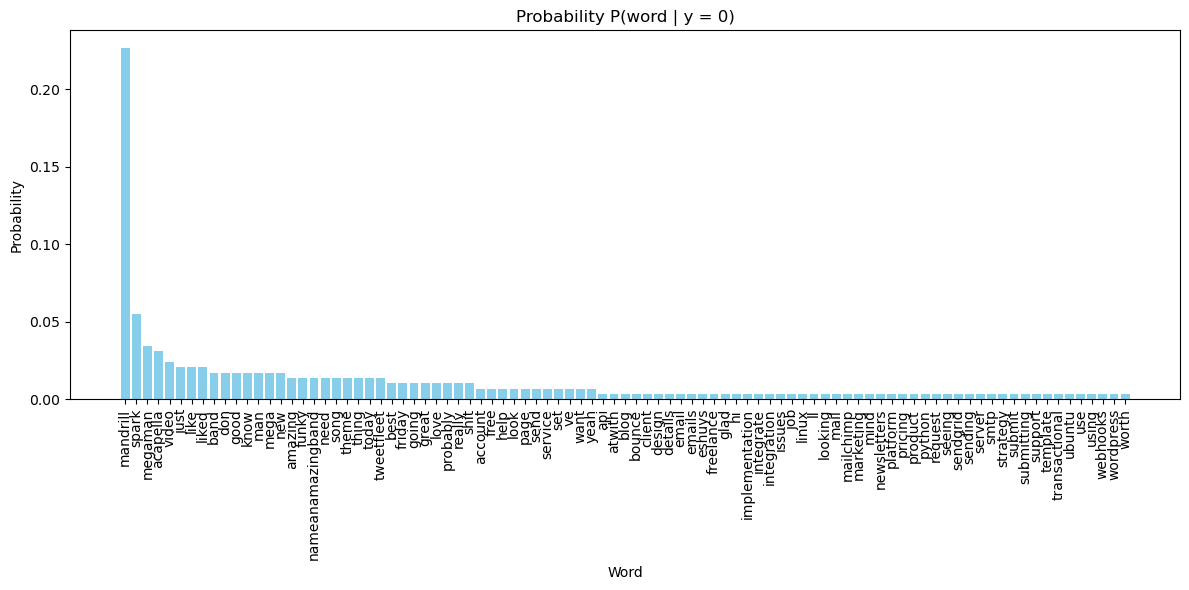

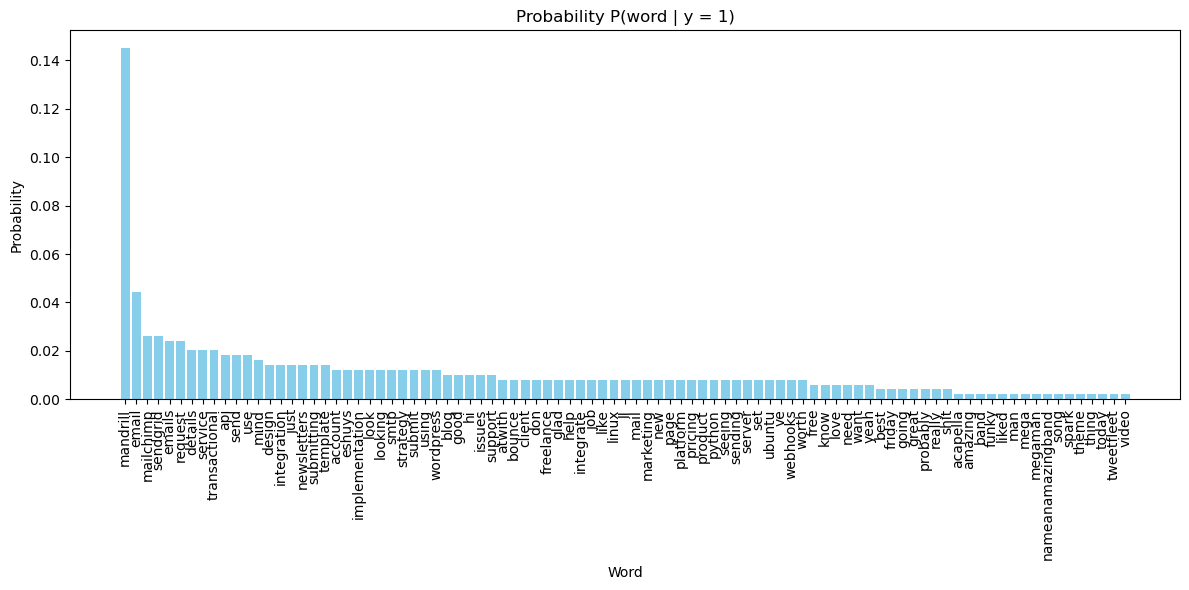

In [9]:
for j in range(probs.shape[0]):
    sorted_indices = sorted(range(len(probs[j])), key=lambda k: probs[j][k], reverse=True)
    sorted_values = [probs[j][i] for i in sorted_indices]
    sorted_words = [words[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_words, sorted_values, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel('Word')
    plt.ylabel('Probability')
    plt.title(f'Probability P(word | y = {j})')
    plt.tight_layout()
    plt.show()